<a href="https://colab.research.google.com/github/userilyo/NLP_Topic_Management/blob/main/E2E_LDA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Topic modeling using LDA
**This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm similar to the NMF algorithm already implemented.
Topic modeling is an unsupervised approach that allows you to explore large text collections.In this example, we use the gensim LDA and pyLDAvis implementations for one type of analysis, as well as the sklearn implementations of LDA and NMF to look at how the models relate to categories in the data.**

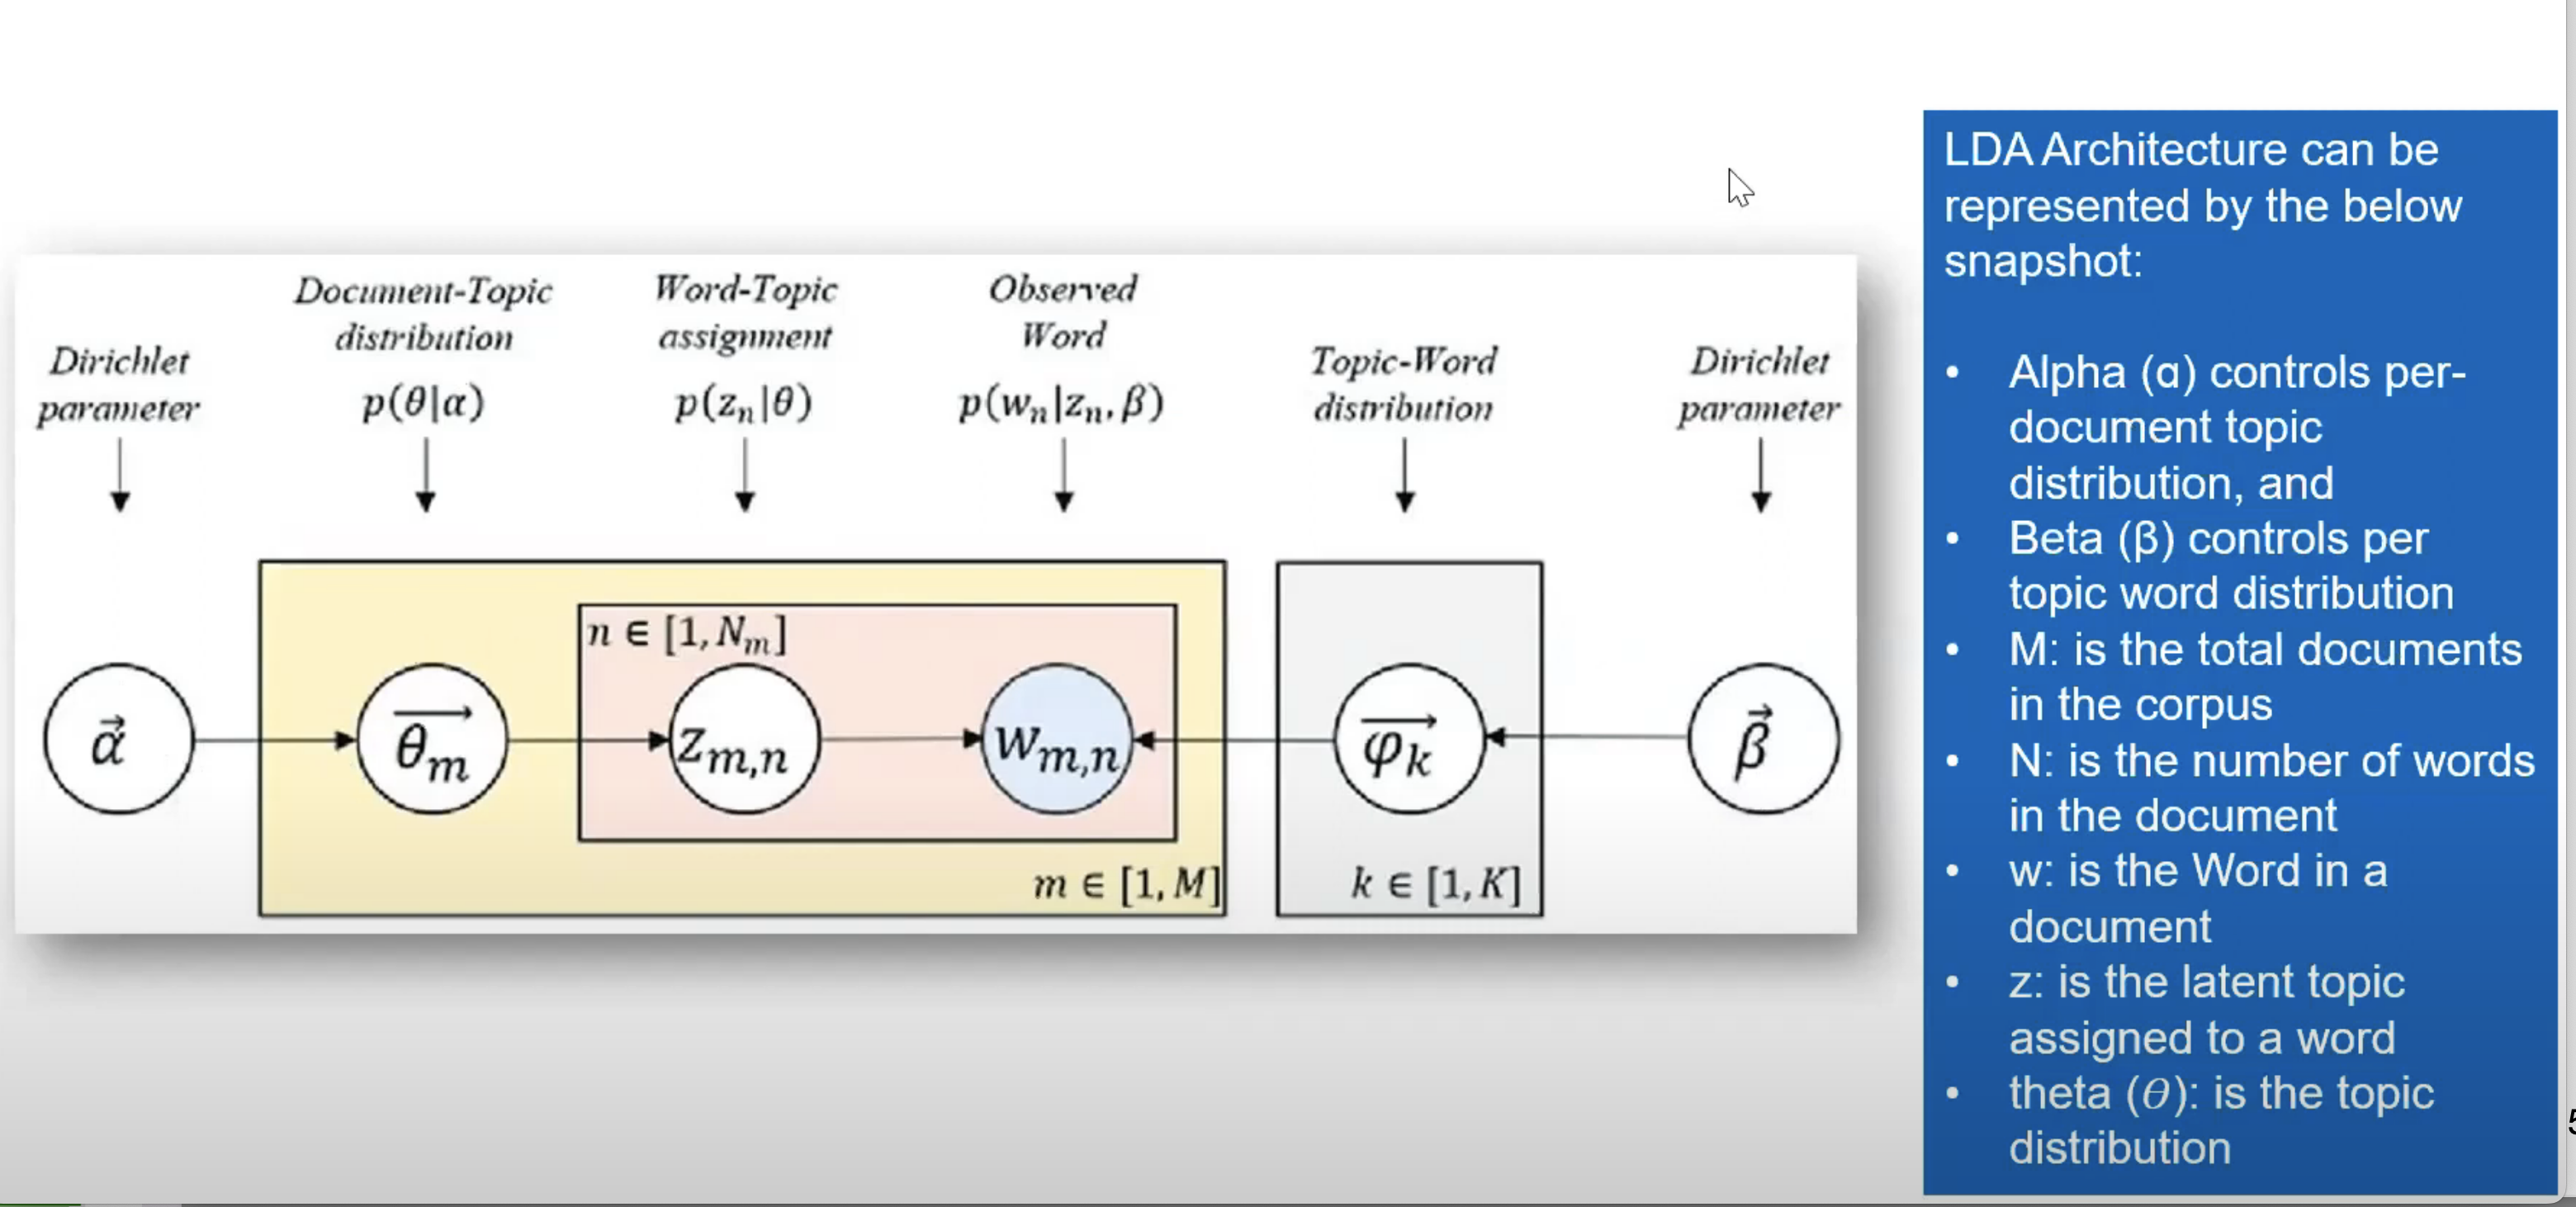

In [ ]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.


#2. Corpus

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
xlds = "/content/drive/MyDrive/Colab Notebooks/Topic Management/data/mtsamples_for_topic_modelling.xlsx"
df = pd.read_excel(xlds)

Mounted at /content/drive


In [ ]:
df.shape

(6385, 6)

In [ ]:
df.head(5)

,Unnamed: 0,index,Category,Document Name,Document Content,Document words
0,0,0,100-ent-otolaryngology,1969-tonsillectomy.txt,PREOPERATIVE D...,"['preoperative', 'diagnosis', 'tonsillitispost..."
1,1,1,100-ent-otolaryngology,2596-bilateralmyringotomies.txt,PREOPERATIVE D...,"['preoperative', 'diagnoses1', 'recurrent', 'a..."
2,2,2,100-ent-otolaryngology,1019-endoscopicsinussurgery.txt,PREOPERATIVE D...,"['preoperative', 'diagnosis1', 'left', 'chroni..."
3,3,3,100-ent-otolaryngology,2735-tracheostomythyroidisthmusectomy.txt,PREOPERATIVE D...,"['preoperative', 'diagnoses1', 'ventilatordepe..."
4,4,4,100-ent-otolaryngology,1469-earlacerationrepair.txt,PREOPERATIVE D...,"['preoperative', 'diagnosis', 'bilateral', 'ea..."


In [ ]:
print(df.Category.nunique())
df['Category'].value_counts()

52


Category
85-surgery                   1103
97-consult                    516
97-consult-historyandphy.     516
6-cardiovascularpulmonary     372
49-orthopedic                 355
95-radiology                  273
98-generalmedicine            259
98-general                    259
24-gastroenterology           230
42-neurology                  223
91-soapchartprogressnotes     166
45-obstetricsgynecology       160
82-urology                    158
89-discharge                  108
89-dischargesummary           108
100-ent-otolaryngology         98
100-ent                        98
43-neurosurgery                94
96-hematology-oncology         90
96-hematology                  90
46-ophthalmology               83
41-nephrology                  81
93-emergency                   75
93-emergencyroomreports        75
66-pediatrics-neonatal         70
66-pediatrics                  70
105-pain                       62
105-painmanagement             62
72-psychiatrypsychology        53
87-of

In [ ]:
import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

#We need to convert the texts to words - let's use a very simple approach
def getWords(row):

  return [''.join(c.lower() for c in s if c not in string.punctuation) for s in nltk.word_tokenize(row)]

df['Document words'] = df['Document Content'].apply(getWords)

#2. Gensim and PyLDAVis application

In [ ]:
## this function returns a set of stopwords predefined in the nltk package

def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

## this function prepares the data and returns a dictionary and a corpus.
## which parameters do you think would be worth modifying/experimenting with?

def prep_corpus(docs, additional_stopwords=set(), no_below=5, no_above=0.5):
  print('Building dictionary...')
  dictionary = Dictionary(docs)
  stopwords = nltk_stopwords().union(additional_stopwords)
  stopword_ids = map(dictionary.token2id.get, stopwords)
  dictionary.filter_tokens(stopword_ids)
  dictionary.compactify()
  dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
  dictionary.compactify()

  print('Building corpus...')
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  return dictionary, corpus

In [ ]:
## now, let's use the functions we defined above to get our dictionary and corpus
dictionary, corpus = prep_corpus(df['Document words'])

Building dictionary...
Building corpus...


In [ ]:
## If you want, you can save your corpus and dictionary to disk for quicker processing later

MmCorpus.serialize('/content/drive/MyDrive/Colab Notebooks/Topic Management/models/mtsamples.mm', corpus)
dictionary.save('/content/drive/MyDrive/Colab Notebooks/Topic Management/models/mtsamples.dict')

In [ ]:
## Now we have our dictionary and corpus, let's generate an LDA model.
## The LDA model has many parameters that can be set, all available parameters can be found here:
## https://radimrehurek.com/gensim/models/ldamodel.html
## Here, we've set the number of topics to 10.

lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

## You can also save the generated model to disk if you want
lda.save('/content/drive/MyDrive/Colab Notebooks/Topic Management/models/mtsamples_20_lda.model')

In [ ]:
## you can now look at these topics by printing them from the generated model

lda.print_topics()

[(0,
  '0.011*"mg" + 0.007*"blood" + 0.006*"pain" + 0.005*"chest" + 0.005*"also" + 0.005*"denies" + 0.005*"disease" + 0.005*"heart" + 0.005*"rate" + 0.004*"medical"'),
 (1,
  '0.011*"procedure" + 0.009*"bladder" + 0.008*"tube" + 0.008*"removed" + 0.007*"placed" + 0.005*"performed" + 0.005*"diagnosis" + 0.005*"ureteral" + 0.005*"biopsy" + 0.005*"stent"'),
 (2,
  '0.009*"mg" + 0.008*"dr" + 0.008*"time" + 0.007*"blood" + 0.006*"po" + 0.005*"surgery" + 0.005*"cancer" + 0.005*"also" + 0.005*"renal" + 0.005*"pain"'),
 (3,
  '0.016*"pain" + 0.008*"also" + 0.007*"back" + 0.006*"time" + 0.006*"dr" + 0.006*"examination" + 0.005*"would" + 0.005*"symptoms" + 0.005*"lower" + 0.004*"states"'),
 (4,
  '0.013*"placed" + 0.009*"procedure" + 0.008*"incision" + 0.008*"used" + 0.007*"skin" + 0.007*"using" + 0.006*"room" + 0.005*"removed" + 0.005*"wound" + 0.005*"operating"'),
 (5,
  '0.007*"exam" + 0.006*"ct" + 0.006*"2" + 0.006*"mass" + 0.005*"revealed" + 0.005*"lobe" + 0.005*"quot" + 0.005*"lung" + 0.00

In [ ]:
import pyLDAvis.gensim
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.226872  0.006651       1        1  21.785297
0     -0.160066  0.037248       2        1  20.541918
3     -0.115179 -0.070966       3        1  12.321986
8      0.123857 -0.175901       4        1   7.682209
7     -0.162746  0.176671       5        1   7.617504
6      0.229358  0.074552       6        1   6.687270
9     -0.151249 -0.163403       7        1   6.671733
5     -0.030459  0.039479       8        1   5.944192
2     -0.119283  0.020909       9        1   5.602454
1      0.158896  0.054761      10        1   5.145437, topic_info=           Term         Freq        Total Category  logprob  loglift
66       placed  7616.000000  7616.000000  Default  30.0000  30.0000
71    procedure  5321.000000  5321.000000  Default  29.0000  29.0000
2262     artery  2970.000000  2970.000000  Default  28.0000  28.0000
182          mg  6000.000000  6000.000000  Default  27.0000  27.0000
312    incision  3774.000000  3774.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
157    evidence   330.437077  3008.289187  Topic10  -5.5972   0.7583
105       using   337.882124  4578.135007  Topic10  -5.5749   0.3607
12      brought   294.580114  1788.737271  Topic10  -5.7121   1.1633
104       upper   303.393041  3190.614916  Topic10  -5.6826   0.6141
819     without   307.511308  5516.672272  Topic10  -5.6691   0.0800

[862 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
2251       1  0.118425      0
2251       2  0.016003      0
2251       3  0.089619      0
2251       4  0.112023      0
2251       5  0.088552      0
...      ...       ...    ...
733        7  0.251480  years
733        8  0.052244  years
733        9  0.058000  years
733       10  0.013725  years
14673      8  0.988903     yo

[2869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 9, 8, 7, 10, 6, 3, 2])